# **Task 1**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Transformation for data normalization
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load CIFAR-10 training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Load CIFAR-10 testing set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


# Task 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super(IntermediateBlock, self).__init__()
        # Create L independent convolutional layers
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            for _ in range(num_layers)
        ])
        # A fully connected layer that outputs the vector a
        self.fc = nn.Linear(in_channels, num_layers)

    def forward(self, x):
        # Compute the average value of each channel of x
        m = torch.mean(x, dim=[2, 3])
        # Compute the vector a
        a = F.softmax(self.fc(m), dim=1)
        # Combine the outputs of each convolutional layer
        x_primes = [conv(x) for conv in self.conv_layers]
        x_prime = torch.stack(x_primes, dim=0)
        a = a.view(a.size(0), a.size(1), 1, 1, 1)
        # Weighted sum of convolutional layer outputs
        x_prime = (a * x_prime).sum(dim=0)
        return x_prime

class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Sequence of zero or more fully connected layers
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        # Compute the average value of each channel of x
        m = self.avgpool(x).view(x.size(0), -1)
        # Output the logits vector o
        o = self.fc(m)
        return o

class MyNeuralNetwork(nn.Module):
    def __init__(self, in_channels, num_blocks, num_layers_per_block, num_classes):
        super(MyNeuralNetwork, self).__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Define the intermediate blocks
        for i in range(num_blocks):
            out_channels = 32 * (2 ** i) # Example of incrementing the number of channels
            num_layers = num_layers_per_block[i]
            block = IntermediateBlock(in_channels if i == 0 else self.blocks[-1].conv_layers[0].out_channels,
                                      out_channels, num_layers)
            self.blocks.append(block)
        # Define the output block
        self.output_block = OutputBlock(out_channels, num_classes)

    def forward(self, x):
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
        x = self.output_block(x)
        return x

# Configuration example
num_blocks = 3
num_layers_per_block = [2, 3, 4]
num_classes = 10

net = MyNeuralNetwork(in_channels=3,
                      num_blocks=num_blocks,
                      num_layers_per_block=num_layers_per_block,
                      num_classes=num_classes)

print(net)


MyNeuralNetwork(
  (blocks): ModuleList(
    (0): IntermediateBlock(
      (conv_layers): ModuleList(
        (0-1): 2 x Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (fc): Linear(in_features=3, out_features=2, bias=True)
    )
    (1): IntermediateBlock(
      (conv_layers): ModuleList(
        (0-2): 3 x Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (fc): Linear(in_features=32, out_features=3, bias=True)
    )
    (2): IntermediateBlock(
      (conv_layers): ModuleList(
        (0-3): 4 x Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (fc): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (output_block): OutputBlock(
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    (fc): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Intermediate Block
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super(IntermediateBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_layers = num_layers

        # Create L independent convolutional layers
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            for _ in range(num_layers)
        ])
        # Fully connected layer for calculating the weights 'a'
        self.weights_fc = nn.Linear(in_channels, num_layers)

    def forward(self, x):
        # Compute the average of each channel to get 'm'
        m = torch.mean(x, [2, 3])

        # Calculate weights 'a'
        a = F.softmax(self.weights_fc(m), dim=1)

        # Combine the outputs of each convolutional layer
        conv_outputs = [conv(x) for conv in self.conv_layers]
        x_prime = sum(a[:, i].unsqueeze(1).unsqueeze(2).unsqueeze(3) * conv_outputs[i] for i in range(self.num_layers))

        return x_prime

# Define the Output Block
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        o = self.fc(x)
        return o

# Define the overall network
class MyNeuralNetwork(nn.Module):
    def __init__(self, in_channels, num_classes, num_blocks, num_layers_per_block):
        super(MyNeuralNetwork, self).__init__()
        self.num_blocks = num_blocks

        # Create the sequence of intermediate blocks
        blocks = []
        for index, num_layers in enumerate(num_layers_per_block):
            out_channels = in_channels * (2 ** index)  # Example way to increase channels
            blocks.append(IntermediateBlock(in_channels, out_channels, num_layers))
            in_channels = out_channels  # The output of the current block is the input for the next
        self.blocks = nn.Sequential(*blocks)

        # Create the output block
        self.output_block = OutputBlock(in_channels, num_classes)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.output_block(x)
        return x

# Assuming we have the following configuration:
in_channels = 3  # RGB channels for CIFAR-10
num_classes = 10  # CIFAR-10 has 10 classes
num_blocks = 3  # Number of intermediate blocks
num_layers_per_block = [2, 2, 3]  # Number of convolutional layers in each intermediate block

# Create the network
network = MyNeuralNetwork(in_channels, num_classes, num_blocks, num_layers_per_block)


# Task 3

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Define the transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)


# Instantiate the network
net = MyNeuralNetwork(in_channels=3, num_blocks=3, num_layers_per_block=[2, 2, 3], num_classes=10)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training loop
for epoch in range(10):  # run the model for 10 epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
        print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000}')
        running_loss = 0.0

        print('Finished Training')

        ##Testing the network
net.eval() # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad(): # For testing, we don't need to compute gradients (for memory efficiency)
 for data in testloader:
  images, labels = data
  images, labels = images.to(device), labels.to(device)
 outputs = net(images)
_, predicted = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f}%')




Files already downloaded and verified
Files already downloaded and verified
Accuracy of the network on the 10000 test images: 25.00%


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 2.1043, Training Accuracy: 20.70%, Test Accuracy: 22.28%
Epoch 2, Loss: 2.0557, Training Accuracy: 22.59%, Test Accuracy: 23.91%
Epoch 3, Loss: 2.0340, Training Accuracy: 23.25%, Test Accuracy: 25.04%
Epoch 4, Loss: 2.0243, Training Accuracy: 24.13%, Test Accuracy: 24.33%
Epoch 5, Loss: 2.0200, Training Accuracy: 24.00%, Test Accuracy: 24.86%
Epoch 6, Loss: 2.0185, Training Accuracy: 24.20%, Test Accuracy: 25.09%
Epoch 7, Loss: 2.0180, Training Accuracy: 24.40%, Test Accuracy: 24.50%
Epoch 8, Loss: 2.0161, Training Accuracy: 24.40%, Test Accuracy: 24.57%
Epoch 9, Loss: 2.0160, Training Accuracy: 24.32%, Test Accuracy: 25.40%
Epoch 10, Loss: 2.0138, Training Accuracy: 24.12%, Test Accuracy: 25.03%
Finished Training


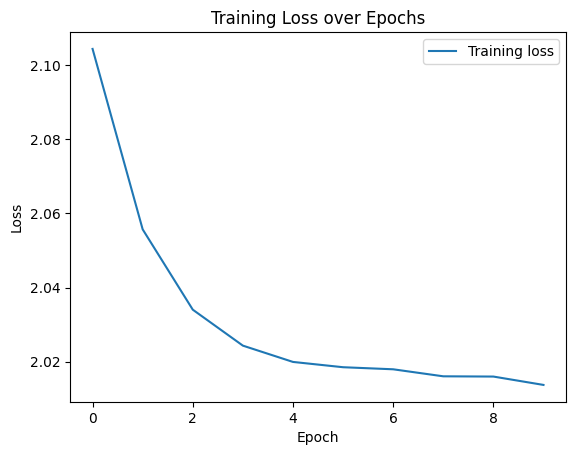

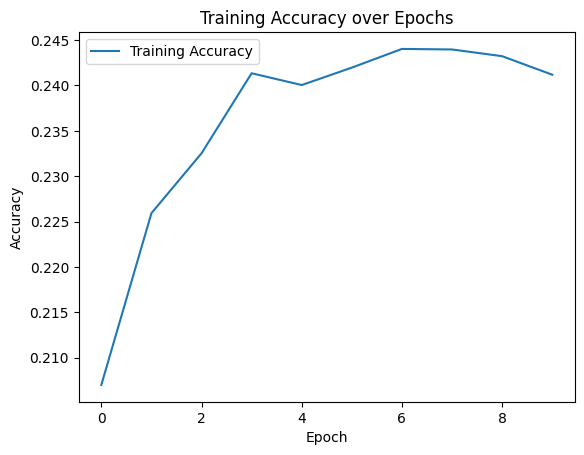

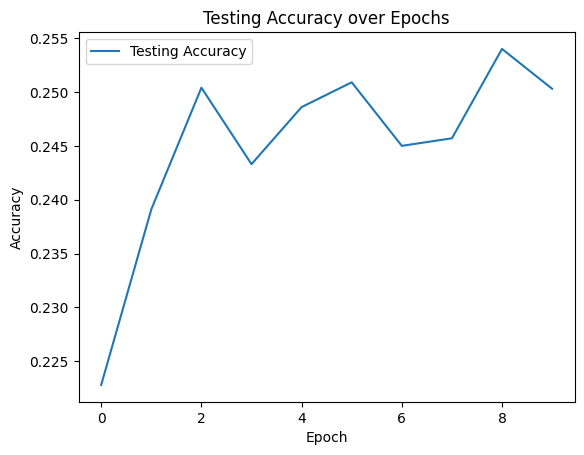

Final accuracy on the test set: 25.03%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Transformations with basic data augmentation for the training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Transformations for the test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Loading the CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Setting up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiating the network
net = MyNeuralNetwork(in_channels=3, num_blocks=3, num_layers_per_block=[2, 2, 3], num_classes=10).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

# Lists for storing metrics
train_losses = []
train_accuracies = []
test_accuracies = []

# Number of epochs
num_epochs = 10

# Training the network
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(trainloader))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Evaluate on test set
    net.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.4f}, '
          f'Training Accuracy: {100 * train_accuracy:.2f}%, '
          f'Test Accuracy: {100 * test_accuracy:.2f}%')

print('Finished Training')

# Plotting the training loss
plt.plot(train_losses, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Plotting the training accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()

# Plotting the testing accuracy
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy over Epochs')
plt.legend()
plt.show()

# Ensure there's no unintended indentation before 'net.eval()'
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f'Final accuracy on the test set: {final_accuracy:.2f}%')


# Task 4

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Data Augmentation for the training set
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Normalization for the test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# CIFAR-10 datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define the neural network with dropout
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 5 * 5, 120)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 5 * 5)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000}')
            running_loss = 0.0

    scheduler.step()  # Adjust the learning rate

print('Finished Training')

# Test the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')


Files already downloaded and verified
Files already downloaded and verified
Finished Training
Accuracy of the network on the 10000 test images: 67.65 %


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

# Define transforms for basic data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Use a pre-trained ResNet18 model and modify it for CIFAR-10
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()

    print(f'Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}')

# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]


Epoch 1, Loss: 2.7434976701541327
Epoch 2, Loss: 1.847203887027243
Epoch 3, Loss: 1.628003674090061
Epoch 4, Loss: 1.485511318801919
Epoch 5, Loss: 1.3565066543686422
Epoch 6, Loss: 1.2406987529581466
Epoch 7, Loss: 1.1395436139667736
Epoch 8, Loss: 1.0847598248735413
Epoch 9, Loss: 1.0307425667562753
Epoch 10, Loss: 0.9968293478421848
Accuracy of the network on the 10000 test images: 64.08 %


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim.lr_scheduler import OneCycleLR

# Advanced Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, fill=128), # fill parameter needs torchvision 0.8.0+
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# CIFAR-10 Datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Leverage a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjust for CIFAR-10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=20)

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}')

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f}%')


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.1464271943282593
Epoch 2, Loss: 1.0076071388276338
Epoch 3, Loss: 1.0761406522272798
Epoch 4, Loss: 1.0355617263737846
Epoch 5, Loss: 0.9330895742796876
Epoch 6, Loss: 0.8727053498368129
Epoch 7, Loss: 0.8183273029754229
Epoch 8, Loss: 0.7868444995806955
Epoch 9, Loss: 0.7271185683472382
Epoch 10, Loss: 0.7023091336040546
Epoch 11, Loss: 0.6602910128243439
Epoch 12, Loss: 0.623938444096719
Epoch 13, Loss: 0.593699176598083
Epoch 14, Loss: 0.5477006356886891
Epoch 15, Loss: 0.5147625924376271
Epoch 16, Loss: 0.46649975301054736
Epoch 17, Loss: 0.4378276138430666
Epoch 18, Loss: 0.402815830600841
Epoch 19, Loss: 0.37475554031484265
Epoch 20, Loss: 0.37112368265991014
Accuracy of the network on the 10000 test images: 86.23%
